# Who said it: Carrie, Miranda, Charlotte, or Samantha?

I couldn't help but wonder...could we predict what line was said by Carrie, Miranda, Charlotte, or Samantha from Sex and the City? Using a dataset by Ceros available on Kaggle, that's exactly what I set out to do. 

I chose the core 4 women because despite the revolving door of love interests, the story is centered on Carrie (main character) and her three best friends (Miranda, Charlotte, Samantha) navigating New York City.

#### Dataset: 
https://www.kaggle.com/snapcrack/every-sex-and-the-city-script

#### Sex and the City Ceros Data Deep Dive:
https://www.ceros.com/originals/sex-and-the-city/

#### Project Inspiration:
http://datameetsmedia.com/jesse-or-celine-text-classification-on-before-sunrise-dialog-part-i/

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

In [2]:
# Read satc.csv into a DataFrame.
path = 'SATC_all_lines.csv'
satc = pd.read_csv(path)

### EDA
Let's hope for the best and see how this goes!

In [3]:
satc.head()

,Unnamed: 0,Season,Episode,Speaker,Line,date_job
0,0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t...",NaN
1,1,1.0,1.0,Carrie,Elizabeth was attractive and bright.,NaN
2,2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...,NaN
3,3,1.0,1.0,Tim,The question remains-- Is this really a compan...,NaN
4,4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm...",NaN


In [4]:
satc.tail()

,Unnamed: 0,Season,Episode,Speaker,Line,date_job
39994,462,6.0,20.0,Big,- What's shaking baby?,NaN
39995,463,6.0,20.0,Carrie,- How's Napa?,NaN
39996,464,6.0,20.0,Big,- The house is on the market.,NaN
39997,465,6.0,20.0,Big,Look out New York. I'm coming.,NaN
39998,466,6.0,20.0,Carrie,"Well, that's just fabulous.",NaN


In [5]:
satc.dtypes

Unnamed: 0     object
Season        float64
Episode       float64
Speaker        object
Line           object
date_job       object
dtype: object

In [10]:
satc.Speaker.value_counts()

Carrie          13941
Miranda          4780
Samantha         4067
Charlotte        3667
Big              1233
                ...  
Aam                 1
Average Date        1
Terry               1
Store rep           1
Both                1
Name: Speaker, Length: 795, dtype: int64

In [11]:
satc.Speaker.nunique()

795

In [12]:
satc.shape

(39999, 6)

In [13]:
# a lot of value counts, but at least our top hits are...Carrie, Miranda, Samantha, Charlotte, and Big
# Makes sense, since (for the most part), they are the main characters
# Not surprised Carrie has way more lines than the  others...why?
# i couldn't help but wonder why?
# duh, her monologues/narration throughout the episode

satc.Speaker.value_counts().head()

Carrie       13941
Miranda       4780
Samantha      4067
Charlotte     3667
Big           1233
Name: Speaker, dtype: int64

In [14]:
# that uppercase speaker is going to drive me wild, let's turn that to lowercase
satc.columns = map(str.lower, satc.columns)

In [15]:
satc.columns

Index(['unnamed: 0', 'season', 'episode', 'speaker', 'line', 'date_job'], dtype='object')

In [16]:
# that unnamed: 0 is going to get on my nerves

satc = satc.rename(columns = {'unnamed: 0':'row_index'})

In [17]:
satc

,row_index,season,episode,speaker,line,date_job
0,0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t...",NaN
1,1,1.0,1.0,Carrie,Elizabeth was attractive and bright.,NaN
2,2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...,NaN
3,3,1.0,1.0,Tim,The question remains-- Is this really a compan...,NaN
4,4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm...",NaN
5,5,1.0,1.0,Carrie,"They met one evening, in typical New York fash...",NaN
6,6,1.0,1.0,Tim,Like it?,NaN
7,7,1.0,1.0,Elizabeth,"Yes, actually. I think it's quite interesting....",NaN
8,8,1.0,1.0,Tim,I feel like I know you from somewhere.,NaN
9,9,1.0,1.0,Elizabeth,Doubtful. I only just moved here from London.,NaN


In [18]:
# do we even need that index?
satc = satc.drop(columns='row_index')

In [19]:
satc

,season,episode,speaker,line,date_job
0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t...",NaN
1,1.0,1.0,Carrie,Elizabeth was attractive and bright.,NaN
2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...,NaN
3,1.0,1.0,Tim,The question remains-- Is this really a compan...,NaN
4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm...",NaN
5,1.0,1.0,Carrie,"They met one evening, in typical New York fash...",NaN
6,1.0,1.0,Tim,Like it?,NaN
7,1.0,1.0,Elizabeth,"Yes, actually. I think it's quite interesting....",NaN
8,1.0,1.0,Tim,I feel like I know you from somewhere.,NaN
9,1.0,1.0,Elizabeth,Doubtful. I only just moved here from London.,NaN


In [20]:
# i'm also not interested in date_job, so we're going to drop that too

satc = satc.drop(columns='date_job')

In [21]:
satc.describe()

,season,episode
count,39989.000000,39988.000000
mean,3.687689,8.895294
std,1.695516,5.324958
min,1.000000,1.000000
25%,2.000000,4.000000
50%,4.000000,8.000000
75%,5.000000,13.000000
max,6.000000,20.000000


In [22]:
# wow, nearly 40K rows! 
# how many of our core spoke comprised of the line counts?
satc.speaker.value_counts().head(4)

Carrie       13941
Miranda       4780
Samantha      4067
Charlotte     3667
Name: speaker, dtype: int64

In [24]:
# when sampling, we need to account that the lines are overwhelmingly attributed to Carrie
# df[ (df['col1'] == value1) & (df['col2'] > value2) ]
satc[ (satc['speaker'] == 'Carrie') | (satc['speaker'] == 'Miranda') | (satc['speaker']  == 'Samantha') | (satc['speaker'] == 'Charlottle')]

,season,episode,speaker,line
0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t..."
1,1.0,1.0,Carrie,Elizabeth was attractive and bright.
2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...
4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm..."
5,1.0,1.0,Carrie,"They met one evening, in typical New York fash..."
13,1.0,1.0,Carrie,It was love at first sight.
15,1.0,1.0,Carrie,For two weeks they snuggled went to romantic r...
16,1.0,1.0,Carrie,One warm spring day he took her to a town hous...
19,1.0,1.0,Carrie,"That day, Tim popped the question."
22,1.0,1.0,Carrie,"On Tuesday, he called with some bad news."


In [25]:
# we're going to be working a lot with just the core 4
# let's spare ourselves the filter and turn it into its own dataset

satc_core4 = satc[ (satc['speaker'] == 'Carrie') | (satc['speaker'] == 'Miranda') | (satc['speaker']  == 'Samantha') | (satc['speaker'] == 'Charlotte')]

In [26]:
satc_core4.head(30)

,season,episode,speaker,line
0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t..."
1,1.0,1.0,Carrie,Elizabeth was attractive and bright.
2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...
4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm..."
5,1.0,1.0,Carrie,"They met one evening, in typical New York fash..."
13,1.0,1.0,Carrie,It was love at first sight.
15,1.0,1.0,Carrie,For two weeks they snuggled went to romantic r...
16,1.0,1.0,Carrie,One warm spring day he took her to a town hous...
19,1.0,1.0,Carrie,"That day, Tim popped the question."
22,1.0,1.0,Carrie,"On Tuesday, he called with some bad news."


In [27]:
# wait how many rows do we have without all the other characters
satc_core4.shape

(26455, 4)

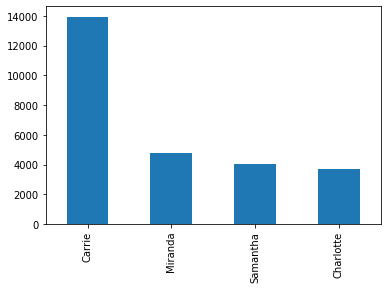

In [28]:
# nearly 26.5K rows of observation? that's like not bad. 
# if we wanted a better model, we could eventually incorporate the 2 movies
# ugh, i honestly just pretend the second movie doesn't exist
# it's trash.
# the series ends with Samantha's 50th at the end of the first movie, that's all. 

satc_core4.speaker.value_counts().plot(kind='bar');

### BIG YIKES on the distribution

Before we address the distribution, let's run the text classification without upsampling/downsampling. This can be our base.

## Attempt 1: SATC Text Classification (Base)

This does not upsample/downsample. Runs everything on a default.

In [29]:
# Define X and y.
X = satc_core4.line
y = satc_core4.speaker

# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [30]:
satc_core4.head()

,season,episode,speaker,line
0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t..."
1,1.0,1.0,Carrie,Elizabeth was attractive and bright.
2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...
4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm..."
5,1.0,1.0,Carrie,"They met one evening, in typical New York fash..."


In [31]:
# Use CountVectorizer to create document-term matrices from X_train and X_test.
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [32]:
# Rows are documents, columns are terms (aka "tokens" or "features", individual words in this situation).
X_train_dtm.shape

(19841, 9127)

In [33]:
# Last 50 features
print((vect.get_feature_names()[-50:]))

['yellow', 'yellows', 'yenta', 'yep', 'yes', 'yesterday', 'yet', 'yeux', 'yikes', 'yip', 'yo', 'yoga', 'york', 'yorke', 'yorkenblatt', 'yorker', 'yorkers', 'you', 'young', 'younger', 'youngest', 'your', 'yours', 'yourself', 'youth', 'youthful', 'youˇ', 'ysl', 'yummy', 'yup', 'yuppie', 'zabar', 'zagat', 'zdravstvuite', 'zebra', 'zen', 'zero', 'zigged', 'zip', 'zipper', 'zit', 'zodiac', 'zone', 'zoo', 'zooey', 'zorro', 'zsa', 'zsu', 'zygote', 'éclairs']


In [34]:
# LOL @ yenta

# Show vectorizer options.
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [35]:
vect.vocabulary_

{'what': 8891,
 'oh': 5576,
 'come': 1654,
 'on': 5595,
 'aren': 463,
 'you': 9094,
 'gonna': 3454,
 'point': 6083,
 'out': 5671,
 'were': 8881,
 'right': 6785,
 'guess': 3555,
 'better': 814,
 'behave': 759,
 'then': 8166,
 'next': 5422,
 'samantha': 6947,
 'all': 308,
 'two': 8481,
 'of': 5556,
 'them': 8163,
 'and': 365,
 'that': 8155,
 'was': 8804,
 'the': 8156,
 'reality': 6503,
 'although': 330,
 'they': 8178,
 'did': 2261,
 'have': 3682,
 'this': 8191,
 'itty': 4221,
 'bitty': 866,
 'thing': 8181,
 'tuna': 8455,
 'loved': 4786,
 'okay': 5580,
 'just': 4350,
 'my': 5319,
 'way': 8839,
 'to': 8279,
 'philly': 5959,
 'wanted': 8789,
 'say': 6996,
 'sorry': 7549,
 'looking': 4754,
 'at': 532,
 'him': 3779,
 'like': 4657,
 'asked': 506,
 'not': 5481,
 'little': 4706,
 'bit': 855,
 'about': 130,
 'me': 5015,
 'might': 5111,
 'never': 5408,
 'find': 3017,
 'lesson': 4607,
 'in': 4026,
 'why': 8932,
 'berger': 799,
 'split': 7629,
 'but': 1191,
 'least': 4565,
 'for': 3149,
 'moment': 5

In [36]:
# convert to lowercase
vect = CountVectorizer(lowercase=True)
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape
vect.get_feature_names()[-10:]

['zit',
 'zodiac',
 'zone',
 'zoo',
 'zooey',
 'zorro',
 'zsa',
 'zsu',
 'zygote',
 'éclairs']

In [37]:
# how does it look now?
vect.vocabulary_

{'what': 8891,
 'oh': 5576,
 'come': 1654,
 'on': 5595,
 'aren': 463,
 'you': 9094,
 'gonna': 3454,
 'point': 6083,
 'out': 5671,
 'were': 8881,
 'right': 6785,
 'guess': 3555,
 'better': 814,
 'behave': 759,
 'then': 8166,
 'next': 5422,
 'samantha': 6947,
 'all': 308,
 'two': 8481,
 'of': 5556,
 'them': 8163,
 'and': 365,
 'that': 8155,
 'was': 8804,
 'the': 8156,
 'reality': 6503,
 'although': 330,
 'they': 8178,
 'did': 2261,
 'have': 3682,
 'this': 8191,
 'itty': 4221,
 'bitty': 866,
 'thing': 8181,
 'tuna': 8455,
 'loved': 4786,
 'okay': 5580,
 'just': 4350,
 'my': 5319,
 'way': 8839,
 'to': 8279,
 'philly': 5959,
 'wanted': 8789,
 'say': 6996,
 'sorry': 7549,
 'looking': 4754,
 'at': 532,
 'him': 3779,
 'like': 4657,
 'asked': 506,
 'not': 5481,
 'little': 4706,
 'bit': 855,
 'about': 130,
 'me': 5015,
 'might': 5111,
 'never': 5408,
 'find': 3017,
 'lesson': 4607,
 'in': 4026,
 'why': 8932,
 'berger': 799,
 'split': 7629,
 'but': 1191,
 'least': 4565,
 'for': 3149,
 'moment': 5

In [38]:
X_train_dtm.shape

(19841, 9127)

In [39]:
# Use default options for CountVectorizer.
vect = CountVectorizer()

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# Use Naive Bayes to predict the star rating.
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.5349259147263381


#### 53% Accuracy -- This is our base?

In [40]:
y_test.value_counts()

Carrie       3495
Miranda      1205
Samantha     1040
Charlotte     874
Name: speaker, dtype: int64

In [41]:
pd.Series(y_pred_class).value_counts()

Carrie       5708
Miranda       435
Samantha      281
Charlotte     190
dtype: int64

In [43]:
# that distribution is rough

# Calculate null accuracy.
y_test_binary = np.where(y_test=='Carrie', 1, 0) # Carrie become 1, Char, Miranda, and Samantha become 0
print('Percent Carrie:', y_test_binary.mean())
print('Percent Not Carrie:', 1 - y_test_binary.mean())

Percent Carrie: 0.5284245539764136
Percent Not Carrie: 0.47157544602358636


In [44]:
# i couldn't help but wonder, could it find Charlotte York?
y_test_charlotte = np.where(y_test=='Charlotte', 1, 0) # five stars become 1, one stars become 0
print('Percent Charlotte:', y_test_charlotte.mean())
print('Percent Not Charlotte:', 1 - y_test_charlotte.mean())

Percent Charlotte: 0.13214393710311462
Percent Not Charlotte: 0.8678560628968854


In [45]:
# Miranda?
y_test_miranda = np.where(y_test=='Miranda', 1, 0) # five stars become 1, one stars become 0
print('Percent Miranda:', y_test_miranda.mean())
print('Percent Not Miranda:', 1 - y_test_miranda.mean())

Percent Miranda: 0.18218929543392803
Percent Not Miranda: 0.817810704566072


In [46]:
# and samantha?
# the model does better in the "not x", why?
# because there's more sample of it being right in the "not x" vs. the "this is x" category

y_test_samantha = np.where(y_test=='Samantha', 1, 0) # five stars become 1, one stars become 0
print('Percent Samantha:', y_test_samantha.mean())
print('Percent Not Samantha:', 1 - y_test_samantha.mean())

Percent Samantha: 0.15724221348654369
Percent Not Samantha: 0.8427577865134563


## So, our model is pretty at predicting when it's Carrie

On a personal note, I find Carrie v. annoying and she's my least favorite.

Unrelated, but I find it karmic justic that I have to find a way to balance Carrie's lines. I guess that's what I get for disliking the main character?

In [47]:
X_train_dtm

<19841x9127 sparse matrix of type '<class 'numpy.int64'>'
	with 136230 stored elements in Compressed Sparse Row format>

In [48]:
X_test_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [49]:
# Define a function that accepts a vectorizer and calculates the accuracy.
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print(('Features: ', X_train_dtm.shape[1]))
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print(('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)))

In [50]:
# min_df ignores words that occur less than twice ('df' means "document frequency").
vect = CountVectorizer(min_df=2, max_features=10000)
tokenize_test(vect)

('Features: ', 4734)
('Accuracy: ', 0.5244934986392501)


In [51]:
# we should remove the stop words

vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [52]:
# Remove English stop words.
vect = CountVectorizer(stop_words='english')
tokenize_test(vect)
vect.get_params()

('Features: ', 8851)
('Accuracy: ', 0.5353794980344724)


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [53]:
tokenize_test(vect)

('Features: ', 8851)
('Accuracy: ', 0.5353794980344724)


In [54]:
# Set of stop words
print((vect.get_stop_words()))

frozenset({'fifty', 'five', 'nothing', 'without', 'their', 'her', 'do', 'beside', 'any', 'ever', 'herself', 'nevertheless', 'still', 'sincere', 'hundred', 'everything', 'became', 'in', 'somewhere', 'someone', 'yet', 'other', 'mill', 'none', 'while', 'ltd', 'nine', 'move', 'seemed', 'she', 'keep', 'each', 'hereupon', 'becomes', 'namely', 'out', 'they', 'would', 'through', 'upon', 'another', 'when', 'nowhere', 'our', 'his', 'too', 'it', 'show', 'where', 'latterly', 'next', 'something', 'via', 'who', 'con', 'whoever', 'will', 'might', 'ourselves', 'must', 'somehow', 'thus', 'become', 'herein', 'or', 'whereafter', 'every', 'during', 'fifteen', 'always', 'couldnt', 'because', 'else', 'by', 'etc', 'less', 'therefore', 'as', 'wherein', 'thereby', 'eight', 'describe', 'done', 'several', 'no', 'but', 'except', 'hence', 'if', 'what', 'with', 'cannot', 'yourselves', 'whether', 'perhaps', 'interest', 'down', 'find', 'bottom', 'two', 'off', 'again', 'name', 'your', 'within', 'myself', 'mostly', 'he

In [55]:
# Include 1-grams and 2-grams.
vect = CountVectorizer(ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape
X_test_dtm = vect.transform(X_test)
# these are like tuning parameters for vectorization

In [56]:
# Use Naive Bayes to predict the star rating.
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.5365890535228304


In [57]:
# Last 50 features
print((vect.get_feature_names()[-50:]))

['yummy courses', 'yup', 'yuppie', 'yuppie guilt', 'zabar', 'zabar and', 'zabar every', 'zabar fish', 'zagat', 'zagat guide', 'zdravstvuite', 'zebra', 'zebra skin', 'zen', 'zen teacher', 'zero', 'zero 35', 'zero dates', 'zero what', 'zigged', 'zigged okay', 'zip', 'zip code', 'zip drive', 'zipper', 'zipper did', 'zit', 'zit is', 'zit when', 'zodiac', 'zodiac sign', 'zone', 'zone book', 'zone when', 'zoo', 'zoo charlotte', 'zooey', 'zorro', 'zsa', 'zsa eww', 'zsa jew', 'zsa zsa', 'zsa zsu', 'zsu', 'zsu gone', 'zsu it', 'zsu or', 'zygote', 'éclairs', 'éclairs she']


In [58]:
# Include 1-grams and 2-grams, and limit the number of features.

print('1-grams and 2-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

1-grams and 2-grams, up to 100K features:
('Features: ', 66198)
('Accuracy: ', 0.5365890535228304)

1-grams only, up to 100K features:
('Features: ', 9127)
('Accuracy: ', 0.5349259147263381)


In [59]:
# Include 1-grams, 2-grams, 3-grams, and 4-grams and limit the number of features.

print('1-grams, 2-grams, 3-grams, and 4-grams up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 4), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

print()
print('2-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(2, 2), max_features=100000)
tokenize_test(vect)

print()
print('3-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(3, 3), max_features=100000)
tokenize_test(vect)

print()
print('4-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(4, 4), max_features=100000)
tokenize_test(vect)

1-grams, 2-grams, 3-grams, and 4-grams up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.5361354702146961)

1-grams only, up to 100K features:
('Features: ', 9127)
('Accuracy: ', 0.5349259147263381)

2-grams only, up to 100K features:
('Features: ', 57071)
('Accuracy: ', 0.523283943150892)

3-grams only, up to 100K features:
('Features: ', 88012)
('Accuracy: ', 0.5204112488660417)

4-grams only, up to 100K features:
('Features: ', 84961)
('Accuracy: ', 0.5279709706682794)


In [62]:
# Include 1-grams and 2-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 2), min_df=2)
tokenize_test(vect)

('Features: ', 18691)
('Accuracy: ', 0.5185969156335047)


In [63]:
# Include 1-grams and 3-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 3), min_df=2)
tokenize_test(vect)

('Features: ', 26464)
('Accuracy: ', 0.5192016933776837)


In [64]:
# Include 1-grams and 4-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 4), min_df=2)
tokenize_test(vect)

('Features: ', 28683)
('Accuracy: ', 0.5222255820985787)


## RECAP Attempt 1:

### For our first attempt, here are some key stats:

1. The imbalance distribution needs to be addressed in future iterations
2. Adding n-grams can improve accuracy (marginally, but still improvement)
3. The model is stronger at accurately predicting Carrie vs. the other characters. In particular, the model struggles with predicting Charlottle.




# Attempt 2: What happens when we downsample Carrie?

#### Source:
1. https://chrisalbon.com/machine_learning/preprocessing_structured_data/handling_imbalanced_classes_with_downsampling/
2. https://elitedatascience.com/imbalanced-classes
https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40

In [65]:
satc_core4.columns

Index(['season', 'episode', 'speaker', 'line'], dtype='object')

In [66]:
# we need to create dummy variables for the speakers
# this will help us identify the lines that have to be weighted
# if it's not carrie, weight normally
# if it's carrie, welp

dummy = pd.get_dummies(satc_core4['speaker'])

In [67]:
dummy.head()

,Carrie,Charlotte,Miranda,Samantha
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
4,1,0,0,0
5,1,0,0,0


In [68]:
core4_dummies = pd.concat([satc_core4, dummy], axis=1)
core4_dummies.head()

,season,episode,speaker,line,Carrie,Charlotte,Miranda,Samantha
0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t...",1,0,0,0
1,1.0,1.0,Carrie,Elizabeth was attractive and bright.,1,0,0,0
2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...,1,0,0,0
4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm...",1,0,0,0
5,1.0,1.0,Carrie,"They met one evening, in typical New York fash...",1,0,0,0


In [69]:
# because i'm paranoid, let's merge on the columns index
core4_dummies = satc_core4.merge(dummy, left_index=True, right_index=True)
core4_dummies.head()

,season,episode,speaker,line,Carrie,Charlotte,Miranda,Samantha
0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t...",1,0,0,0
1,1.0,1.0,Carrie,Elizabeth was attractive and bright.,1,0,0,0
2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...,1,0,0,0
4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm...",1,0,0,0
5,1.0,1.0,Carrie,"They met one evening, in typical New York fash...",1,0,0,0


In [70]:
core4_dummies.speaker.value_counts()

Carrie       13941
Miranda       4780
Samantha      4067
Charlotte     3667
Name: speaker, dtype: int64

In [71]:
# okay, now that we know how to isolate Carrie's lines
# i couldn't help but wonder, how should we downsample Carrie?
y_test.value_counts()

#Carrie       3495
#Miranda      1205
#Samantha     1040
#Charlotte     874

Carrie       3495
Miranda      1205
Samantha     1040
Charlotte     874
Name: speaker, dtype: int64

In [72]:
# is charlotte (tbh, my favorite) undersampled???

y_train.value_counts()
# Carrie       10446
# Miranda       3575
# Samantha      3027
# Charlotte     2793

Carrie       10446
Miranda       3575
Samantha      3027
Charlotte     2793
Name: speaker, dtype: int64

In [73]:
# Separate majority and minority classes
c4_majority = core4_dummies[core4_dummies.Carrie==1]
c4_minority = core4_dummies[core4_dummies.Carrie==0]

In [74]:
c4_majority.speaker.value_counts()

Carrie    13941
Name: speaker, dtype: int64

In [75]:
c4_minority.speaker.value_counts()

Miranda      4780
Samantha     4067
Charlotte    3667
Name: speaker, dtype: int64

In [76]:
# Downsample majority class
from sklearn.utils import resample

c4_majority_ds = resample(c4_majority,
                         replace=False, # sample without replacement
                         n_samples=5000, # to match minority class
                         random_state=123) # reproducible results

In [77]:
# Combine minority class with downsampled majority class
c4_downsampled = pd.concat([c4_majority_ds, c4_minority])

In [78]:
# Display new class counts
c4_downsampled.speaker.value_counts()

# initially i had Carrie set to 4,171 which is the average of Miranda, Samantha, and Charlotte
# but that would make Miranda have the most lines, which I really didn't like either
# because Carrie is the main character

# new:
# Carrie       5000
# Miranda      4780
# Samantha     4067
# Charlotte    3667
# Name: speaker, dtype: int64

Carrie       5000
Miranda      4780
Samantha     4067
Charlotte    3667
Name: speaker, dtype: int64

In [79]:
c4_downsampled.head()

,season,episode,speaker,line,Carrie,Charlotte,Miranda,Samantha
29126,5.0,5.0,Carrie,"- Thanks for coming, Berger.",1,0,0,0
7246,2.0,8.0,Carrie,Are you telling me that you are seriously capa...,1,0,0,0
15500,3.0,10.0,Carrie,Go tomorrow.,1,0,0,0
26445,4.0,18.0,Carrie,"The air is crisp, the summer is gone.",1,0,0,0
9735,2.0,15.0,Carrie,We want to meet Wesley of Wesley and Leslie.,1,0,0,0


In [80]:
# Define X and y with new downsampling dataset
X = c4_downsampled.line
y = c4_downsampled.speaker

In [81]:
# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [82]:
# Use CountVectorizer to create document-term matrices from X_train and X_test.
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [83]:
# Rows are documents, columns are terms (aka "tokens" or "features", individual words in this situation).
X_train_dtm.shape

(13135, 7031)

In [84]:
# Last 50 features
print((vect.get_feature_names()[-50:]))

['ya', 'yael', 'yale', 'yankee', 'yankees', 'yay', 'ye', 'yeah', 'year', 'years', 'yell', 'yelled', 'yellow', 'yep', 'yes', 'yesterday', 'yet', 'yi', 'yoga', 'york', 'yorke', 'yorkenblatt', 'yorker', 'yorkers', 'you', 'young', 'younger', 'your', 'yours', 'yourself', 'yourselves', 'youth', 'youthful', 'ysl', 'yuck', 'yup', 'zagat', 'zdravstvuite', 'zebra', 'zen', 'zero', 'zipper', 'zipping', 'zit', 'zone', 'zoo', 'zorro', 'zsa', 'zsu', 'éclairs']


In [85]:
# Show vectorizer options.
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [86]:
vect.vocabulary_

{'or': 4403,
 'at': 412,
 'least': 3569,
 'for': 2440,
 'now': 4295,
 'honey': 3001,
 'you': 7005,
 'should': 5610,
 'get': 2627,
 'on': 4372,
 'that': 6266,
 'it': 3281,
 'dorm': 1894,
 'was': 6762,
 'the': 6267,
 'dentist': 1718,
 'can': 977,
 'guarantee': 2756,
 'donald': 1887,
 'trump': 6480,
 'and': 276,
 'marlo': 3861,
 'thomas': 6296,
 'yes': 6995,
 'mrs': 4128,
 'friends': 2518,
 'something': 5793,
 'is': 3271,
 'good': 2684,
 'enough': 2080,
 'laundry': 3544,
 'room': 5282,
 're': 5037,
 'sexy': 5542,
 'ok': 4359,
 'valium': 6645,
 'everything': 2140,
 'oh': 4357,
 'missed': 4040,
 'those': 6301,
 'hands': 2818,
 'women': 6921,
 'use': 6627,
 'their': 6270,
 'sexuality': 5540,
 'to': 6367,
 'ahead': 200,
 'whenever': 6835,
 'possible': 4779,
 'but': 928,
 'men': 3958,
 'not': 4281,
 'be': 541,
 'allowed': 241,
 'take': 6165,
 'advantage': 167,
 'of': 4340,
 'just': 3397,
 'saying': 5398,
 'are': 354,
 'equal': 2096,
 'opportunity': 4396,
 'exploiters': 2197,
 'he': 2872,
 'usu

In [87]:
# Don't convert to lowercase.
vect = CountVectorizer(lowercase=True)
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape
vect.get_feature_names()[-10:]

['zero',
 'zipper',
 'zipping',
 'zit',
 'zone',
 'zoo',
 'zorro',
 'zsa',
 'zsu',
 'éclairs']

In [88]:
X_train_dtm.shape

(13135, 7031)

In [89]:
# Use default options for CountVectorizer.
vect = CountVectorizer()

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# Use Naive Bayes to predict the star rating.
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.40306005937428635


In [90]:
# surprise! the accuracy score actually goes down when we downsample Carrie
# we went from ~53% to now 40%.
# yikes yikes yikes

y_test.value_counts()

Carrie       1256
Miranda      1145
Samantha     1035
Charlotte     943
Name: speaker, dtype: int64

In [91]:
pd.Series(y_pred_class).value_counts()

Miranda      1752
Carrie       1385
Samantha      652
Charlotte     590
dtype: int64

In [92]:
# Calculate null accuracy.
y_test_binary = np.where(y_test=='Carrie', 1, 0) # Carrie become 1, Char, Miranda, and Samantha become 0
print('Percent Carrie:', y_test_binary.mean())
print('Percent Not Carrie:', 1 - y_test_binary.mean())

Percent Carrie: 0.2868234756793789
Percent Not Carrie: 0.7131765243206212


In [93]:
# i couldn't help but wonder, could it find Charlotte York?
y_test_charlotte = np.where(y_test=='Charlotte', 1, 0) # five stars become 1, one stars become 0
print('Percent Charlotte:', y_test_charlotte.mean())
print('Percent Not Charlotte:', 1 - y_test_charlotte.mean())

Percent Charlotte: 0.21534596939940626
Percent Not Charlotte: 0.7846540306005938


In [94]:
# Miranda?
y_test_miranda = np.where(y_test=='Miranda', 1, 0) # five stars become 1, one stars become 0
print('Percent Miranda:', y_test_miranda.mean())
print('Percent Not Miranda:', 1 - y_test_miranda.mean())

Percent Miranda: 0.26147522265357387
Percent Not Miranda: 0.7385247773464261


In [95]:
# and samantha?
# the model does better in the "not x", why?
# because there's more sample of it being right in the "not x" vs. the "this is x" category

y_test_samantha = np.where(y_test=='Samantha', 1, 0) # five stars become 1, one stars become 0
print('Percent Samantha:', y_test_samantha.mean())
print('Percent Not Samantha:', 1 - y_test_samantha.mean())

Percent Samantha: 0.23635533226764102
Percent Not Samantha: 0.763644667732359


In [96]:
# the model's accuracy went down down down, especially for Carrie
# makes sense, we removed a lot of Carrie's observations

X_train_dtm

<13135x7031 sparse matrix of type '<class 'numpy.int64'>'
	with 86202 stored elements in Compressed Sparse Row format>

In [97]:
vect.vocabulary_

{'or': 4403,
 'at': 412,
 'least': 3569,
 'for': 2440,
 'now': 4295,
 'honey': 3001,
 'you': 7005,
 'should': 5610,
 'get': 2627,
 'on': 4372,
 'that': 6266,
 'it': 3281,
 'dorm': 1894,
 'was': 6762,
 'the': 6267,
 'dentist': 1718,
 'can': 977,
 'guarantee': 2756,
 'donald': 1887,
 'trump': 6480,
 'and': 276,
 'marlo': 3861,
 'thomas': 6296,
 'yes': 6995,
 'mrs': 4128,
 'friends': 2518,
 'something': 5793,
 'is': 3271,
 'good': 2684,
 'enough': 2080,
 'laundry': 3544,
 'room': 5282,
 're': 5037,
 'sexy': 5542,
 'ok': 4359,
 'valium': 6645,
 'everything': 2140,
 'oh': 4357,
 'missed': 4040,
 'those': 6301,
 'hands': 2818,
 'women': 6921,
 'use': 6627,
 'their': 6270,
 'sexuality': 5540,
 'to': 6367,
 'ahead': 200,
 'whenever': 6835,
 'possible': 4779,
 'but': 928,
 'men': 3958,
 'not': 4281,
 'be': 541,
 'allowed': 241,
 'take': 6165,
 'advantage': 167,
 'of': 4340,
 'just': 3397,
 'saying': 5398,
 'are': 354,
 'equal': 2096,
 'opportunity': 4396,
 'exploiters': 2197,
 'he': 2872,
 'usu

In [98]:
X_test_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [99]:
# min_df ignores words that occur less than twice ('df' means "document frequency").
vect = CountVectorizer(min_df=2, max_features=10000)
tokenize_test(vect)

('Features: ', 3457)
('Accuracy: ', 0.40146152089518156)


In [100]:
# we should remove the stop words

vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [101]:
# Remove English stop words.
vect = CountVectorizer(stop_words='english')
tokenize_test(vect)
vect.get_params()

('Features: ', 6767)
('Accuracy: ', 0.3966659054578671)


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [102]:
tokenize_test(vect)

# ugh, my accuracy is really down, nooo

('Features: ', 6767)
('Accuracy: ', 0.3966659054578671)


In [103]:
# Set of stop words
print((vect.get_stop_words()))

frozenset({'fifty', 'five', 'nothing', 'without', 'their', 'her', 'do', 'beside', 'any', 'ever', 'herself', 'nevertheless', 'still', 'sincere', 'hundred', 'everything', 'became', 'in', 'somewhere', 'someone', 'yet', 'other', 'mill', 'none', 'while', 'ltd', 'nine', 'move', 'seemed', 'she', 'keep', 'each', 'hereupon', 'becomes', 'namely', 'out', 'they', 'would', 'through', 'upon', 'another', 'when', 'nowhere', 'our', 'his', 'too', 'it', 'show', 'where', 'latterly', 'next', 'something', 'via', 'who', 'con', 'whoever', 'will', 'might', 'ourselves', 'must', 'somehow', 'thus', 'become', 'herein', 'or', 'whereafter', 'every', 'during', 'fifteen', 'always', 'couldnt', 'because', 'else', 'by', 'etc', 'less', 'therefore', 'as', 'wherein', 'thereby', 'eight', 'describe', 'done', 'several', 'no', 'but', 'except', 'hence', 'if', 'what', 'with', 'cannot', 'yourselves', 'whether', 'perhaps', 'interest', 'down', 'find', 'bottom', 'two', 'off', 'again', 'name', 'your', 'within', 'myself', 'mostly', 'he

In [104]:
# Include 1-grams and 2-grams.
vect = CountVectorizer(ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape
X_test_dtm = vect.transform(X_test)
# these are like tuning parameters for vectorization

In [105]:
# Use Naive Bayes to predict the star rating.
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.4037451472939027


In [108]:
# Last 75 features
print((vect.get_feature_names()[-75:]))

['your underwear', 'your undivided', 'your vagina', 'your veal', 'your water', 'your way', 'your wedding', 'your whites', 'your whole', 'your wholesale', 'your wife', 'your window', 'your wood', 'your word', 'your words', 'your work', 'your world', 'your worlds', 'your worldwide', 'yours', 'yours are', 'yours in', 'yours say', 'yours yours', 'yourself', 'yourself and', 'yourself before', 'yourself comfortable', 'yourself from', 'yourself in', 'yourself into', 'yourself man', 'yourself on', 'yourself that', 'yourself up', 'yourself very', 'yourself with', 'yourselves', 'youth', 'youth obsessed', 'youthful', 'youthful doppelgangers', 'ysl', 'yuck', 'yup', 'zagat', 'zagat guide', 'zdravstvuite', 'zebra', 'zebra skin', 'zen', 'zen teacher', 'zero', 'zero 35', 'zero what', 'zipper', 'zipper did', 'zipping', 'zipping up', 'zit', 'zit when', 'zone', 'zone when', 'zoo', 'zorro', 'zsa', 'zsa eww', 'zsa jew', 'zsa zsa', 'zsa zsu', 'zsu', 'zsu gone', 'zsu or', 'éclairs', 'éclairs she']


In [109]:
# Include 1-grams and 2-grams, and limit the number of features.

print('1-grams and 2-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

1-grams and 2-grams, up to 100K features:
('Features: ', 45960)
('Accuracy: ', 0.4037451472939027)

1-grams only, up to 100K features:
('Features: ', 7031)
('Accuracy: ', 0.40306005937428635)


In [110]:
# Include 1-grams, 2-grams, 3-grams, and 4-grams and limit the number of features.

print('1-grams, 2-grams, 3-grams, and 4-grams up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 4), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

print()
print('2-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(2, 2), max_features=100000)
tokenize_test(vect)

print()
print('3-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(3, 3), max_features=100000)
tokenize_test(vect)

print()
print('4-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(4, 4), max_features=100000)
tokenize_test(vect)

1-grams, 2-grams, 3-grams, and 4-grams up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.3994062571363325)

1-grams only, up to 100K features:
('Features: ', 7031)
('Accuracy: ', 0.40306005937428635)

2-grams only, up to 100K features:
('Features: ', 38929)
('Accuracy: ', 0.35396209180178123)

3-grams only, up to 100K features:
('Features: ', 55984)
('Accuracy: ', 0.3130851792646723)

4-grams only, up to 100K features:
('Features: ', 52377)
('Accuracy: ', 0.30417903630965976)


In [111]:
# Include 1-grams and 2-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 2), min_df=2)
tokenize_test(vect)

('Features: ', 12410)
('Accuracy: ', 0.4058004110527518)


In [112]:
# Include 1-grams and 3-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 3), min_df=2)
tokenize_test(vect)

('Features: ', 16771)
('Accuracy: ', 0.4067138616122402)


In [113]:
# Include 1-grams and 4-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 4), min_df=2)
tokenize_test(vect)

('Features: ', 17942)
('Accuracy: ', 0.40831240009134506)


## RECAP Attempt 2:

### For our second attempt, here are some key stats:

1. Addressing the imbalanced class distributions will affect the accuracy of the model.
2. Downsampling Carrie actually lowered the overall accuracy scores
3. Accuracy scores dipped after adding n-grams more than 2
4. Downsampling Carrie's observations didn't just weaken the accuracy scores for Carrie. It actually weakened accuracy for predicting the other three characters as well. 

Sigh.





## Attempt 3: What happens if we upsample Charlotte, Miranda, and Samantha?

In [115]:
# Define X and y.
X = satc_core4.line
y = satc_core4.speaker

# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [116]:
# Separate majority and minority classes
c4_majority = core4_dummies[core4_dummies.Carrie==1]
c4_minority = core4_dummies[core4_dummies.Carrie==0]

In [117]:
c4_majority.speaker.value_counts()

Carrie    13941
Name: speaker, dtype: int64

In [118]:
c4_minority.speaker.value_counts()

Miranda      4780
Samantha     4067
Charlotte    3667
Name: speaker, dtype: int64

In [119]:
# Upsample minority class
c4_minority_us = resample(c4_minority,
                          replace=True,     # sample with replacement
                          n_samples=13941,    # to match majority class
                          random_state=123) # reproducible results

In [120]:
# Combine majority class with upsampled minority class
c4_upsampled = pd.concat([c4_majority, c4_minority_us])

In [121]:
# Display new class counts
c4_upsampled.speaker.value_counts()

#Carrie       13941
#Miranda       5232
#Samantha      4547
#Charlotte     4162
#Name: speaker, dtype: int64

Carrie       13941
Miranda       5232
Samantha      4547
Charlotte     4162
Name: speaker, dtype: int64

In [122]:
# :|
c4_upsampled.head()

,season,episode,speaker,line,Carrie,Charlotte,Miranda,Samantha
0,1.0,1.0,Carrie,"Once upon a time, an English journalist came t...",1,0,0,0
1,1.0,1.0,Carrie,Elizabeth was attractive and bright.,1,0,0,0
2,1.0,1.0,Carrie,Right away she hooked up with one of the city'...,1,0,0,0
4,1.0,1.0,Carrie,"Tim was 42, a well-liked and respected investm...",1,0,0,0
5,1.0,1.0,Carrie,"They met one evening, in typical New York fash...",1,0,0,0


In [123]:
c4_upsampled.tail()

,season,episode,speaker,line,Carrie,Charlotte,Miranda,Samantha
38519,6.0,17.0,Charlotte,"Seriously, I could not believe how many dogs s...",0,1,0,0
14239,3.0,7.0,Miranda,- What's wrong?,0,0,1,0
29224,5.0,6.0,Charlotte,- Matthew Bloom of Bloom & Goldenblatt. What's...,0,1,0,0
37326,6.0,15.0,Miranda,Ow,0,0,1,0
37802,6.0,16.0,Miranda,"Yeah, neither do I.",0,0,1,0


In [124]:
# Define X and y with new upsampling dataset
X = c4_upsampled.line
y = c4_upsampled.speaker

In [125]:
# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [126]:
X

0        Once upon a time, an English journalist came t...
1                     Elizabeth was attractive and bright.
2        Right away she hooked up with one of the city'...
4        Tim was 42, a well-liked and respected investm...
5        They met one evening, in typical New York fash...
                               ...                        
38519    Seriously, I could not believe how many dogs s...
14239                                      - What's wrong?
29224    - Matthew Bloom of Bloom & Goldenblatt. What's...
37326                                                   Ow
37802                                  Yeah, neither do I.
Name: line, Length: 27882, dtype: object

In [127]:
y

0           Carrie
1           Carrie
2           Carrie
4           Carrie
5           Carrie
           ...    
38519    Charlotte
14239      Miranda
29224    Charlotte
37326      Miranda
37802      Miranda
Name: speaker, Length: 27882, dtype: object

In [128]:
# Use CountVectorizer to create document-term matrices from X_train and X_test.
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [129]:
# Rows are documents, columns are terms (aka "tokens" or "features", individual words in this situation).
X_train_dtm.shape

(20911, 8701)

In [137]:
# Last 50 features
print((vect.get_feature_names()[-50:]))

['yeast', 'yell', 'yelled', 'yelling', 'yellow', 'yellows', 'yenta', 'yep', 'yes', 'yesterday', 'yet', 'yi', 'yikes', 'yip', 'yo', 'yoga', 'york', 'yorke', 'yorker', 'yorkers', 'you', 'young', 'younger', 'youngest', 'your', 'yours', 'yourself', 'youth', 'youthful', 'yummy', 'yup', 'yuppie', 'zabar', 'zagat', 'zdravstvuite', 'zebra', 'zen', 'zero', 'zip', 'zipper', 'zipping', 'zit', 'zodiac', 'zone', 'zoo', 'zooey', 'zorro', 'zsa', 'zsu', 'éclairs']


In [138]:
# Show vectorizer options.
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [139]:
vect.vocabulary_

{'why': 8515,
 'don': 2304,
 'you': 8671,
 'go': 3276,
 'over': 5449,
 'and': 351,
 'say': 6687,
 'hello': 3571,
 'we': 8437,
 'gotta': 3322,
 'figure': 2851,
 'out': 5431,
 'what': 8482,
 're': 6204,
 'doing': 2290,
 'here': 3587,
 'he': 3531,
 'the': 7785,
 'regular': 6291,
 'jerk': 4076,
 'du': 2392,
 'soleil': 7178,
 'getting': 3227,
 'ready': 6217,
 'for': 2997,
 'this': 7820,
 'big': 797,
 'exhibit': 2661,
 'at': 517,
 'some': 7186,
 'paris': 5548,
 'museum': 5065,
 'or': 5389,
 'they': 7808,
 'freaked': 3061,
 'by': 1162,
 'their': 7790,
 'own': 5479,
 'feelings': 2807,
 've': 8272,
 'just': 4155,
 'only': 5357,
 'been': 724,
 'week': 8455,
 'so': 7163,
 'do': 2276,
 'like': 4454,
 'my': 5081,
 'skunk': 7075,
 'really': 6226,
 'excuse': 2653,
 'me': 4790,
 'grow': 3387,
 'up': 8219,
 'hi': 3602,
 'yesterday': 8660,
 'almost': 308,
 'did': 2166,
 'it': 4029,
 'with': 8558,
 'him': 3621,
 'on': 5349,
 'park': 5550,
 'bench': 764,
 'in': 3854,
 'front': 3102,
 'of': 5309,
 'childre

In [140]:
# Don't convert to lowercase.
vect = CountVectorizer(lowercase=True)
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape
vect.get_feature_names()[-10:]

['zipping',
 'zit',
 'zodiac',
 'zone',
 'zoo',
 'zooey',
 'zorro',
 'zsa',
 'zsu',
 'éclairs']

In [141]:
X_train_dtm.shape

(20911, 8701)

In [142]:
# Use default options for CountVectorizer.
vect = CountVectorizer()

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# Use Naive Bayes to predict the star rating.
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.5752402811648257


In [143]:
# ayeeeee, our accuracy improved! we went from the downsampled ~40% to now ~58%! 
# even our base model didn't perform at ~58%, it was more ~54%

y_test.value_counts()

Carrie       3555
Miranda      1281
Samantha     1112
Charlotte    1023
Name: speaker, dtype: int64

In [144]:
pd.Series(y_pred_class).value_counts()

Carrie       5406
Miranda       644
Samantha      473
Charlotte     448
dtype: int64

In [145]:
# Calculate null accuracy.
y_test_binary = np.where(y_test=='Carrie', 1, 0) # Carrie become 1, Char, Miranda, and Samantha become 0
print('Percent Carrie:', y_test_binary.mean())
print('Percent Not Carrie:', 1 - y_test_binary.mean())

Percent Carrie: 0.5099698751972457
Percent Not Carrie: 0.4900301248027543


In [146]:
# and with Charlotte?
# i couldn't help but wonder, could it find Charlotte York?
y_test_charlotte = np.where(y_test=='Charlotte', 1, 0) # five stars become 1, one stars become 0
print('Percent Charlotte:', y_test_charlotte.mean())
print('Percent Not Charlotte:', 1 - y_test_charlotte.mean())

Percent Charlotte: 0.1467508248457897
Percent Not Charlotte: 0.8532491751542103


In [147]:
# Miranda?
y_test_miranda = np.where(y_test=='Miranda', 1, 0) # five stars become 1, one stars become 0
print('Percent Miranda:', y_test_miranda.mean())
print('Percent Not Miranda:', 1 - y_test_miranda.mean())

Percent Miranda: 0.18376129680103284
Percent Not Miranda: 0.8162387031989672


In [148]:
# and samantha?
# the model does better in the "not x", why?
# because there's more sample of it being right in the "not x" vs. the "this is x" category

y_test_samantha = np.where(y_test=='Samantha', 1, 0) # five stars become 1, one stars become 0
print('Percent Samantha:', y_test_samantha.mean())
print('Percent Not Samantha:', 1 - y_test_samantha.mean())

Percent Samantha: 0.1595180031559317
Percent Not Samantha: 0.8404819968440683


In [149]:
# while the model is only marginally (as in barely) better at predicting the other girls exclusively
# by upsampling the girls, the model is able to retain its accuracy for Carrie
# and Carrie's accuracy scoring was pretty solid

X_train_dtm

<20911x8701 sparse matrix of type '<class 'numpy.int64'>'
	with 142673 stored elements in Compressed Sparse Row format>

In [150]:
vect.vocabulary_

{'why': 8515,
 'don': 2304,
 'you': 8671,
 'go': 3276,
 'over': 5449,
 'and': 351,
 'say': 6687,
 'hello': 3571,
 'we': 8437,
 'gotta': 3322,
 'figure': 2851,
 'out': 5431,
 'what': 8482,
 're': 6204,
 'doing': 2290,
 'here': 3587,
 'he': 3531,
 'the': 7785,
 'regular': 6291,
 'jerk': 4076,
 'du': 2392,
 'soleil': 7178,
 'getting': 3227,
 'ready': 6217,
 'for': 2997,
 'this': 7820,
 'big': 797,
 'exhibit': 2661,
 'at': 517,
 'some': 7186,
 'paris': 5548,
 'museum': 5065,
 'or': 5389,
 'they': 7808,
 'freaked': 3061,
 'by': 1162,
 'their': 7790,
 'own': 5479,
 'feelings': 2807,
 've': 8272,
 'just': 4155,
 'only': 5357,
 'been': 724,
 'week': 8455,
 'so': 7163,
 'do': 2276,
 'like': 4454,
 'my': 5081,
 'skunk': 7075,
 'really': 6226,
 'excuse': 2653,
 'me': 4790,
 'grow': 3387,
 'up': 8219,
 'hi': 3602,
 'yesterday': 8660,
 'almost': 308,
 'did': 2166,
 'it': 4029,
 'with': 8558,
 'him': 3621,
 'on': 5349,
 'park': 5550,
 'bench': 764,
 'in': 3854,
 'front': 3102,
 'of': 5309,
 'childre

In [151]:
X_test_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [152]:
# min_df ignores words that occur less than twice ('df' means "document frequency").
vect = CountVectorizer(min_df=2, max_features=10000)
tokenize_test(vect)

('Features: ', 4918)
('Accuracy: ', 0.558886816812509)


In [153]:
# another marked improvement. 

# we should remove the stop words

vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [154]:
# Remove English stop words.
vect = CountVectorizer(stop_words='english')
tokenize_test(vect)
vect.get_params()

('Features: ', 8430)
('Accuracy: ', 0.5759575383732607)


{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [155]:
tokenize_test(vect)

('Features: ', 8430)
('Accuracy: ', 0.5759575383732607)


In [156]:
# Set of stop words
print((vect.get_stop_words()))

frozenset({'fifty', 'five', 'nothing', 'without', 'their', 'her', 'do', 'beside', 'any', 'ever', 'herself', 'nevertheless', 'still', 'sincere', 'hundred', 'everything', 'became', 'in', 'somewhere', 'someone', 'yet', 'other', 'mill', 'none', 'while', 'ltd', 'nine', 'move', 'seemed', 'she', 'keep', 'each', 'hereupon', 'becomes', 'namely', 'out', 'they', 'would', 'through', 'upon', 'another', 'when', 'nowhere', 'our', 'his', 'too', 'it', 'show', 'where', 'latterly', 'next', 'something', 'via', 'who', 'con', 'whoever', 'will', 'might', 'ourselves', 'must', 'somehow', 'thus', 'become', 'herein', 'or', 'whereafter', 'every', 'during', 'fifteen', 'always', 'couldnt', 'because', 'else', 'by', 'etc', 'less', 'therefore', 'as', 'wherein', 'thereby', 'eight', 'describe', 'done', 'several', 'no', 'but', 'except', 'hence', 'if', 'what', 'with', 'cannot', 'yourselves', 'whether', 'perhaps', 'interest', 'down', 'find', 'bottom', 'two', 'off', 'again', 'name', 'your', 'within', 'myself', 'mostly', 'he

In [157]:
# Include 1-grams and 2-grams.
vect = CountVectorizer(ngram_range=(1, 2))
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm.shape
X_test_dtm = vect.transform(X_test)
# these are like tuning parameters for vectorization

In [158]:
# Use Naive Bayes to predict the star rating.
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.662602209152202


In [159]:
# Include 1-grams and 2-grams, and limit the number of features.

print('1-grams and 2-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 2), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

1-grams and 2-grams, up to 100K features:
('Features: ', 61532)
('Accuracy: ', 0.662602209152202)

1-grams only, up to 100K features:
('Features: ', 8701)
('Accuracy: ', 0.5752402811648257)


In [160]:
# Include 2-grams and 3-grams, and limit the number of features.

print('2-grams and 3-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(2, 3), max_features=100000)
tokenize_test(vect)

print()
print('2-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(2, 2), max_features=100000)
tokenize_test(vect)

2-grams and 3-grams, up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.6848371826136853)

2-grams only, up to 100K features:
('Features: ', 52831)
('Accuracy: ', 0.6676230096112465)


In [161]:
# Include 3-grams and 4-grams, and limit the number of features.

print('3-grams and 4-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(3, 4), max_features=100000)
tokenize_test(vect)

print()
print('3-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(3, 3), max_features=100000)
tokenize_test(vect)

3-grams and 4-grams, up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.6702051355616124)

3-grams only, up to 100K features:
('Features: ', 80078)
('Accuracy: ', 0.6813943480131975)


In [162]:
# Include 4-grams and 5-grams, and limit the number of features.

print('4-grams and 5-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(4, 5), max_features=100000)
tokenize_test(vect)

print()
print('4-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(4, 4), max_features=100000)
tokenize_test(vect)

print()
print('5-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(5, 5), max_features=100000)
tokenize_test(vect)

4-grams and 5-grams, up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.6664753980777507)

4-grams only, up to 100K features:
('Features: ', 77003)
('Accuracy: ', 0.675369387462344)

5-grams only, up to 100K features:
('Features: ', 66442)
('Accuracy: ', 0.6518433510256778)


In [163]:
# Include 2-grams and 3-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(2, 3), min_df=2)
tokenize_test(vect)

('Features: ', 32599)
('Accuracy: ', 0.6165542963706785)


In [164]:
# Include 1-grams and 2-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(1, 2), min_df=1)
tokenize_test(vect)

('Features: ', 61532)
('Accuracy: ', 0.662602209152202)


In [166]:
# Include 3-grams and 4-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(3, 4), min_df=1)
tokenize_test(vect)

('Features: ', 157081)
('Accuracy: ', 0.6812508965715105)


In [167]:
# Include 4-grams and 5-grams, and only include terms that appear at least two times.
vect = CountVectorizer(ngram_range=(4, 5), min_df=1)
tokenize_test(vect)

('Features: ', 143445)
('Accuracy: ', 0.675512838904031)


In [165]:
# Include 1-grams, 2-grams, and 3-grams, and limit the number of features.

print('1-grams, 2-grams, and 3-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 3), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

print()
print('2-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(2, 2), max_features=100000)
tokenize_test(vect)

print()
print('3-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(3, 3), max_features=100000)
tokenize_test(vect)

1-grams, 2-grams, and 3-grams, up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.6780949648543968)

1-grams only, up to 100K features:
('Features: ', 8701)
('Accuracy: ', 0.5752402811648257)

2-grams only, up to 100K features:
('Features: ', 52831)
('Accuracy: ', 0.6676230096112465)

3-grams only, up to 100K features:
('Features: ', 80078)
('Accuracy: ', 0.6813943480131975)


In [169]:
# Include up to 5-grams and limit the number of features.

print('1-5-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 5), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

print()
print('2-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(2, 2), max_features=100000)
tokenize_test(vect)

print()
print('3-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(3, 3), max_features=100000)
tokenize_test(vect)

print()
print('4-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(4, 4), max_features=100000)
tokenize_test(vect)

print()
print('5-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(5, 5), max_features=100000)
tokenize_test(vect)

1-5-grams, up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.6446707789413284)

1-grams only, up to 100K features:
('Features: ', 8701)
('Accuracy: ', 0.5752402811648257)

2-grams only, up to 100K features:
('Features: ', 52831)
('Accuracy: ', 0.6676230096112465)

3-grams only, up to 100K features:
('Features: ', 80078)
('Accuracy: ', 0.6813943480131975)

4-grams only, up to 100K features:
('Features: ', 77003)
('Accuracy: ', 0.675369387462344)

5-grams only, up to 100K features:
('Features: ', 66442)
('Accuracy: ', 0.6518433510256778)


In [173]:
### and four grams???

# Include up to 4-grams and limit the number of features.

print('1-4-grams, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 4), max_features=100000)
tokenize_test(vect)

print()
print('1-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(1, 1), max_features=100000)
tokenize_test(vect)

print()
print('2-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(2, 2), max_features=100000)
tokenize_test(vect)

print()
print('3-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(3, 3), max_features=100000)
tokenize_test(vect)

print()
print('4-grams only, up to 100K features:')
vect = CountVectorizer(ngram_range=(4, 4), max_features=100000)
tokenize_test(vect)

1-4-grams, up to 100K features:
('Features: ', 100000)
('Accuracy: ', 0.662889112035576)

1-grams only, up to 100K features:
('Features: ', 8701)
('Accuracy: ', 0.5752402811648257)

2-grams only, up to 100K features:
('Features: ', 52831)
('Accuracy: ', 0.6676230096112465)

3-grams only, up to 100K features:
('Features: ', 80078)
('Accuracy: ', 0.6813943480131975)

4-grams only, up to 100K features:
('Features: ', 77003)
('Accuracy: ', 0.675369387462344)


In [175]:
# Include 1-grams and 2-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(1, 2), min_df=2)
tokenize_test(vect)

('Features: ', 22196)
('Accuracy: ', 0.6197102280877923)


In [176]:
# Include 1-grams through 3-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(1, 3), min_df=2)
tokenize_test(vect)

('Features: ', 37517)
('Accuracy: ', 0.6222923540381581)


In [177]:
# Include 1-grams and 4-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(1, 4), min_df=2)
tokenize_test(vect)

('Features: ', 48082)
('Accuracy: ', 0.6115334959116339)


In [178]:
# Include 1-grams and 5-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(1, 5), min_df=2)
tokenize_test(vect)

('Features: ', 55966)
('Accuracy: ', 0.6043609238272845)


In [179]:
# Include 2-grams and 4-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(2, 4), min_df=2)
tokenize_test(vect)

('Features: ', 43164)
('Accuracy: ', 0.6116769473533209)


In [180]:
# Include 3-grams and 4-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(3, 4), min_df=2)
tokenize_test(vect)

('Features: ', 25886)
('Accuracy: ', 0.5832735618992971)


In [181]:
# Include 3-grams and 4-grams, and only include terms that appear at least 2 times.
vect = CountVectorizer(ngram_range=(2, 3), min_df=2)
tokenize_test(vect)

('Features: ', 32599)
('Accuracy: ', 0.6165542963706785)


In [171]:
# okay, so including up to 3-grams appears optimal. Once we begin including 4 and 5-grams,
# the accuracy begins to dip indicating diminishing return after 3-grams

## RECAP Attempt 3:

### For our third (and final) attempt, here are some key stats:

1. Addressing the imbalanced class distributions affects the accuracy of the model.
2. Upsampling Charlottle, Miranda, and Samantha actually IMPROVED the overall accuracy scores. The first attempt's score was ~53%. When we downsampled Carrie, the score became ~40%. In our recent attempt, the initial accuracy score improves to ~58%. 
3. Accuracy scores improved when we added up 1, 2, and 3-grams. Improved the accuracy to ~68%. 
4. However, there was a point of diminishing return when we began including 4 and 5-grams. The sweet spot was really when we included up to 3-grams.
